In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.patches as mpatches
from statannot import add_stat_annotation

from tqdm import tqdm
import warnings 
import copy

import itertools
import math
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels.stats.multitest import multipletests
import scipy

fig_path = 'figures/'#'/data2/hratch/cci_dt/figures/'
data_path = 'data/'#'/data2/hratch/cci_dt/noise_v_error/'
version = 1
lfc_threshold = -1.1 # min LFC change to use a rank higher than 4
heuristic_error = 0.3 # threshold at which to check error level

In [15]:
# load iteration results
fn = data_path + 'error_vs_noise_' + str(version) + '_noise0_'
noise_max = [0.001, 0.01, 0.05, 0.1, 0.15, 0.20, 0.25]
res = dict()
res = {nm: {'all_res': pd.read_csv(fn + '{:.2f}'.format(nm).split('.')[1] + '.tab', sep = '\t')} if nm >= 0.01 else \
       pd.read_csv(fn + '{:.3f}'.format(nm).split('.')[1] + '.tab', sep = '\t') for nm in noise_max[1:]}


for nm, df in res.items():
    df['all_res']['noise_max'] = nm


In [16]:
def LFC(a,b):
    '''Fold change from a to b'''
    return np.log(b) - np.log(a)

def get_min_error(res):
    '''For each noise iteration, gets the rank of the decomposition which best minimized error'''
    res_min = pd.DataFrame(columns = res.columns)
    counter = 0
    
    for idx in tqdm(range(0, res.shape[0], 3)):
        temp = res.loc[idx:idx +2, :] # 3 ranks and errors for one iteration
        # get minimum error (with threshold LFC decrease)
        rank = 4
        min_error = temp.loc[idx, 'Error']
        for i in range(idx+1,idx+3):
            next_error = temp.loc[i, 'Error']
            if LFC(min_error, next_error) < lfc_threshold:
                min_error = next_error
                rank = temp.loc[i, 'Rank']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res_min.loc[counter,:] =  [res.loc[idx, 'Noise'], min_error, rank, res.loc[idx, 'noise_max']]  
        counter += 1
        
    res_min.Rank = res_min.Rank.astype(int)
    for col in ['Noise', 'Error', 'noise_max']:
        res_min[col] = res_min[col].astype(float)
    return res_min

def get_lowess_fit(res_min):
    '''Fits a lowess curve using sm, then finds a function to interpolate noise from lowess-predicted error values'''
    loess_fit = pd.DataFrame(sm_lowess(endog = res_min.Error, exog = res_min.Noise),
                        columns = ['Noise', 'Predicted_Error'])
    loess_fit.drop_duplicates(keep = 'first', inplace = True)
    loess_fit.reset_index(drop = True, inplace = True)
    interp_fit = scipy.interpolate.interp1d(x = loess_fit.Predicted_Error,y = loess_fit.Noise,
                                     bounds_error=False)
    return loess_fit, interp_fit

def zscore_(x):
    '''Sample zscore'''
    return scipy.stats.zscore(x, ddof = 1)

In [17]:
res_temp = copy.deepcopy(res)

loess_res_all = None
for nm, res_ in res_temp.items():
    print(nm)
    res_min_ = get_min_error(res_['all_res'])
    res[nm]['min_res'] = res_min_ # choose rank that minimizes error for each iteration
    
    # fit a lowess curve to noise vs error
    loess_res_, fit_ = get_lowess_fit(res_min_) 
    loess_res_['Maximum Background Noise'] = nm
    if loess_res_all is None:
        loess_res_all = loess_res_
    else:
        loess_res_all = pd.concat([loess_res_all, loess_res_])

    res[nm]['loess_fit'] = fit_
    print('------------')
del res_temp
loess_res_all.to_csv(data_path + 'loess_fit_values.csv')    

  1%|          | 109/19000 [00:00<00:17, 1083.69it/s]

0.01


  1%|          | 111/19000 [00:00<00:17, 1108.51it/s]

------------
0.05


  1%|          | 113/19000 [00:00<00:16, 1128.56it/s]

------------
0.1


  1%|          | 110/19000 [00:00<00:17, 1099.16it/s]

------------
0.15


  1%|          | 114/19000 [00:00<00:16, 1130.79it/s]

------------
0.2


  1%|          | 114/19000 [00:00<00:16, 1133.32it/s]

------------
0.25


100%|██████████| 19000/19000 [00:25<00:00, 744.96it/s]


------------


''

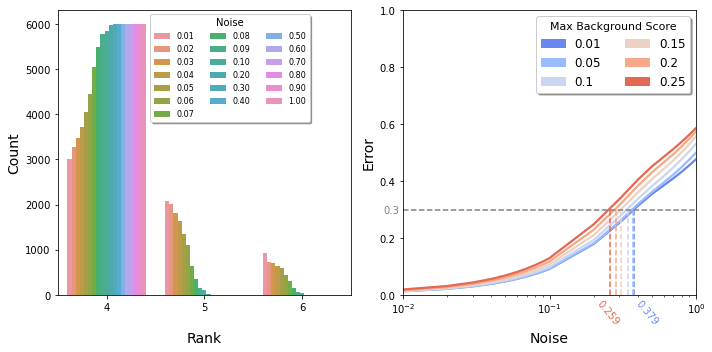

In [31]:
fontsize = 14
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)
colors = sns.color_palette("coolwarm", len(res))

# sns.color_palette("tab10")[2]] + [sns.color_palette("tab10")[0]]
#------#------#------#------#------count plot
viz_df = None
for nm, res_ in res.items():
    if viz_df is None:
        viz_df = res_['min_res']
    else:
        viz_df = pd.concat([viz_df, res_['min_res']])
sns.countplot(x = 'Rank', hue = 'Noise', data = viz_df, ax = ax[0])
handles, labels = ax[0].get_legend_handles_labels()
labels = [labels[0]] + ['{:.2f}'.format(float(i)) for i in labels[1:]]
ax[0].legend(labels=labels, handles = handles, bbox_to_anchor=(0, 0, 1.175,1), title = 'Noise', ncol = 3, 
            fancybox = True, shadow = True, fontsize = 8)
#---------------------------------------------------------------------------------------------------------
xval = dict()
cmap = dict()
cmap_leg = dict()
for idx, (nm, res_) in enumerate(res.items()):
    sns.regplot(x = 'Noise', y = 'Error', lowess = True, data = res_['min_res'], ax = ax[1], scatter = False, 
                color = colors[idx])
    x_fit = res_['loess_fit'](heuristic_error)
    ax[1].axvline(x = x_fit, ymax = heuristic_error, 
              color = colors[idx], linestyle = '--')
    
    cmap_leg[colors[idx]] = str(nm)
    if idx == 0 or idx == (len(res) - 1): # only first and last
        xval[x_fit.tolist()] = idx
        cmap[colors[idx]] = str(nm)



ax[1].set_xscale('log')
ax[1].set_ylim(0,1)
# annotate values from the heuristic threshold
ax[1].axhline(y = heuristic_error, color = 'gray', linestyle = '--')

yticks = sorted(set(list(ax[1].get_yticks()) + [heuristic_error]))
cmap_ = {i: 'black' if i != heuristic_error else 'gray' for i in yticks}
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(labels = ['{:.1f}'.format(i) for i in yticks])#, color = [cmap[i] for i in yticks])
ax[1].get_yticklabels()[yticks.index(heuristic_error)].set_color('gray') 
ytick = ax[1].yaxis.get_major_ticks()[yticks.index(heuristic_error)]
ytick.tick1line.set_visible(False)
ytick.set_pad(0.005)


# # Method A
# xval = {fit1(heuristic_error).tolist(): 0, 
#         fit2(heuristic_error).tolist(): 1}
# offset = [0.06,-0.16]
# str_map = ['<-- ', '--> ']
# for xv, idx in xval.items():
#     if idx == 0:
#         ax[1].annotate(text = str_map[idx] + '{:.3f}'.format(xv), xy = (xv + offset[idx],0.01), 
#                       color = colors[idx], fontsize = 11)
#     else:
#         ax[1].annotate(text = '{:.3f}'.format(xv) + str_map[idx], xy = (xv + offset[idx],0.01), 
#                       color = colors[idx], fontsize = 11)

# # Method B
# xval = {fit1(heuristic_error).tolist(): 0, 
#         fit2(heuristic_error).tolist(): 1}
# offset = [0.02,-0.12]
# for xv, idx in xval.items():
#     ax[1].annotate(text = '{:.3f}'.format(xv), xy = (xv + offset[idx],0.01), 
#                   color = colors[idx], fontsize = 11)

# Method C
change_ = [0.08, None, None, None, None, -0.01]# [0.08, 0, -0.005, -0.01] # offset padding
rot_ = [310]*len(res) # label rotation
xvals = list(xval.keys())
xticks = sorted(set(list(ax[1].get_xticks()[1:-1]) + xvals))
cmap_ = {i: 'black' if i not in xvals else colors[xval[i]] for i in xticks}
ax[1].set_xticks([i if i not in xval else i + change_[xval[i]] for i in xticks])# generate an offset
ax[1].set_xticklabels(labels = ['$\\mathdefault{10^{' + str(int('{:1.0e}'.format(i).split('e')[1])) + '}}$' if \
                                i not in xvals else '{:.3f}'.format(i) for i in xticks])
for v,idx in xval.items():
    ax[1].get_xticklabels()[xticks.index(v)].set_color(colors[idx]) 
    xtick = ax[1].xaxis.get_major_ticks()[xticks.index(v)]
    xtick.tick1line.set_visible(False)
    xtick.set_pad(0.001)
    xtick.label1.set_rotation(rot_[idx])

patches = [mpatches.Patch(color=c, label=nm) for c,nm in cmap_leg.items()]
leg1=ax[1].legend(handles=patches, title = 'Max Background Score', bbox_to_anchor=(1, 1), 
             fancybox = True, shadow = True, fontsize = 12, ncol=2)
plt.setp(leg1.get_title(),fontsize=11)
for i in range(2):
    ax[i].set_ylabel(ylabel = ax[i].get_ylabel().capitalize(),fontsize = 14)
    ax[i].set_xlabel(xlabel = ax[i].get_xlabel().capitalize(),fontsize = 14)

fig.align_xlabels(ax[:])
plt.tight_layout()

for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(fig_path + 'background_noise_means_noscale' + ext, bbox_inches = 'tight')
;

visually confirm that the scipy interpolation well matches the plotted lowess

In [42]:
viz_df.Rank.value_counts()/viz_df.shape[0]

4.0    0.861051
5.0    0.098742
6.0    0.040207
Name: Rank, dtype: float64

Lines are the lowess fit values. Scatterplot points are the interpolated values from the lowess fit:

In [32]:
interp = dict()
for nm, res_ in res.items():
    interp_ = pd.DataFrame(data = {'Error': np.arange(0,1,0.01)})
    interp_['Noise'] = res_['loess_fit'](interp_.Error)
    interp_.dropna(inplace = True)
    interp[nm] = interp_

''

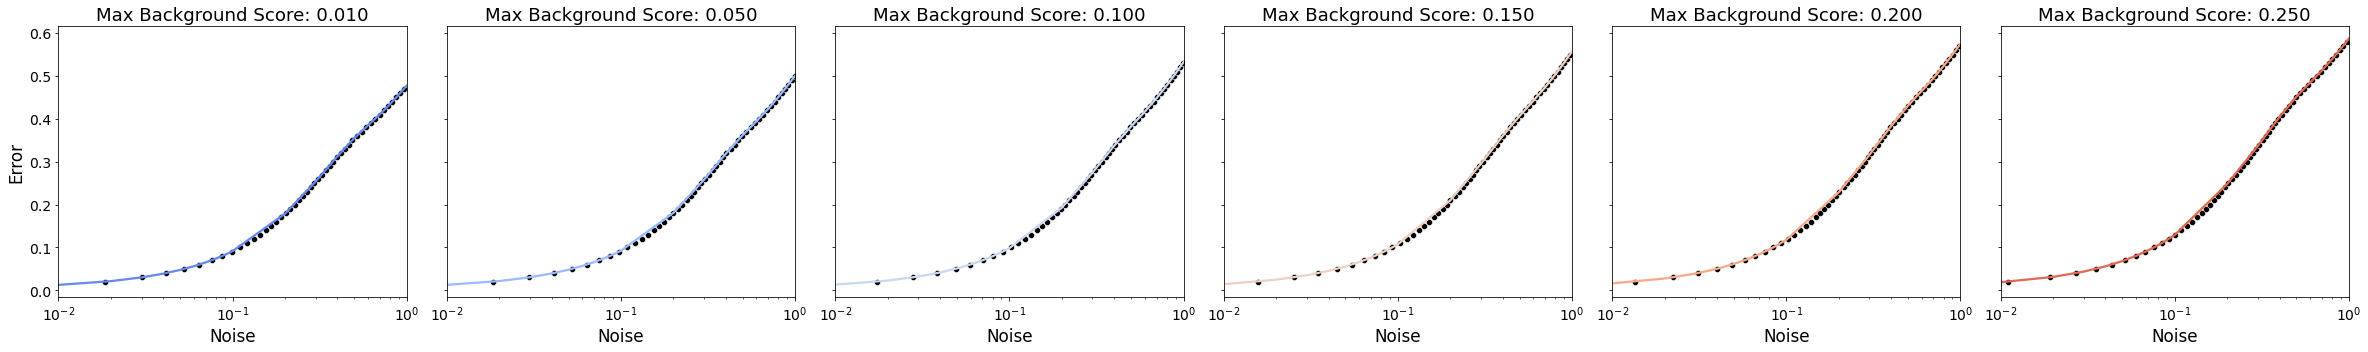

In [33]:
fontsize = 14
fig, ax = plt.subplots(figsize = (5.5*len(res),5), ncols = len(res), sharey = True)
for idx, (nm, df) in enumerate(interp.items()):
    sns.scatterplot(y = 'Error', x= 'Noise', data = interp[nm], color = 'black', ax = ax[idx])
    sns.regplot(x = 'Noise', y = 'Error', 
                lowess = True, data = res[nm]['min_res'], ax = ax[idx], scatter = False, color = colors[idx])
    ax[idx].set_xscale('log')
    ax[idx].set_ylabel(ax[idx].get_ylabel(), fontsize = 1.2*fontsize)
    ax[idx].set_xlabel(ax[idx].get_xlabel(), fontsize = 1.2*fontsize)
    ax[idx].set_title('Max Background Score: {:.3f}'.format(nm), fontsize = 1.3*fontsize)
    ax[idx].tick_params(axis='both', labelsize=fontsize)

fig.align_xlabels(ax[:])
plt.tight_layout()

for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(fig_path + 'interpolation_vs_loess' + ext, bbox_inches = 'tight')
;

# Compare 0.05 and 0.25

In [34]:
stat_map = {0.05: '*', 0.01: '**', 0.0001: '***', 0.00001: '****'}
# offset = {'*': -0.1, '**': -0.3, '***': -0.4, '****': -0.4}
offset = {'*': -0.02, '**': -0.04, '***': -0.06, '****': -0.08}


def get_symb(fdr_):
    '''Return asterisk corresponding to significance value'''
    symb = ''
    for sig_, symb_ in stat_map.items():
        if fdr_ <= sig_:
            symb = symb_
    return symb

In [35]:
stat_df = None
for nm, res_ in res.items():
    if stat_df is None:
        stat_df = res_['min_res']
    else:
        stat_df = pd.concat([stat_df, res_['min_res']])
stat_df.reset_index(inplace = True, drop = True)
viz_df = stat_df.copy()

# remove outliers for visualization purposes---------------
true_error = pd.DataFrame(viz_df.groupby(['Noise', 'noise_max'])['Error'].apply(lambda x: list(x))).explode('Error').reset_index()
zscore_error = pd.DataFrame(viz_df.groupby(['Noise', 'noise_max'])['Error'].apply(lambda x: zscore_(x))).apply(lambda x: list(x)).explode('Error').reset_index()

viz_df['zscore_error'] = zscore_error.Error.astype(float)
viz_df = viz_df[viz_df.zscore_error.abs() <= 1.96]

# format df for seaborn---------------
viz_df['log_Noise'] = np.log10(viz_df.Noise)
for col in viz_df.columns:
    viz_df[col] = viz_df[col].astype(float)

''

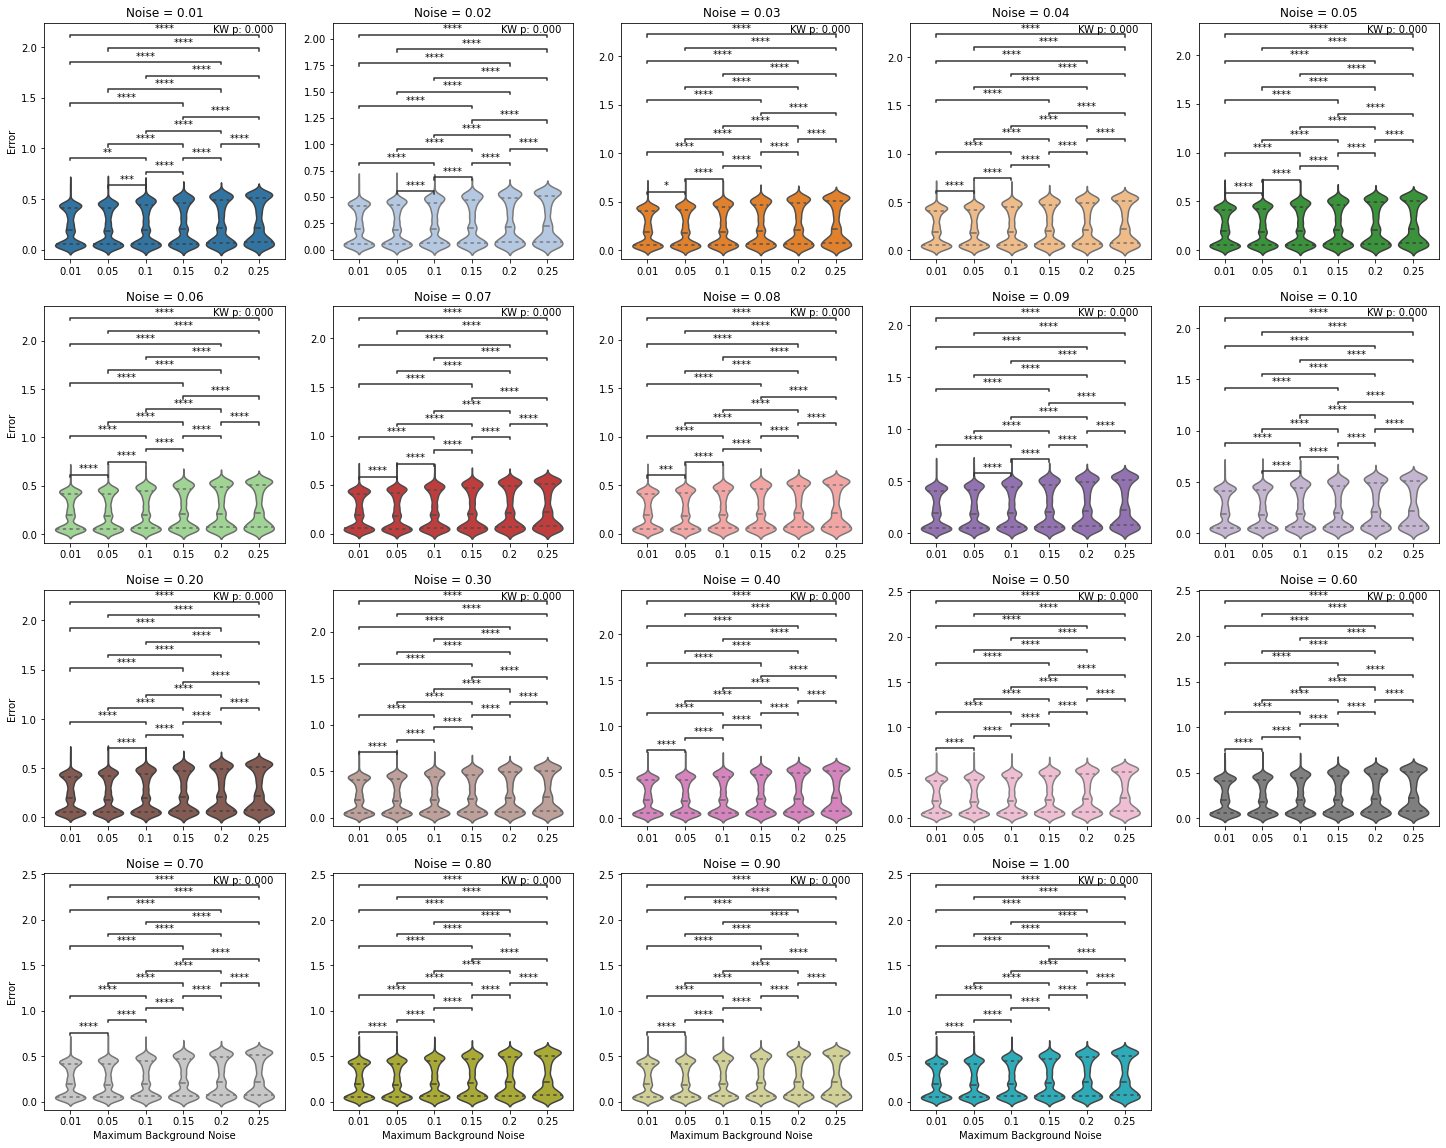

In [41]:
noise_vals = sorted(viz_df.Noise.unique())
nm_order = sorted(viz_df.noise_max.unique())
box_coords = {v:idx for idx,v in enumerate(nm_order)}
comparisons = list(itertools.combinations(nm_order, 2))
n_noise = len(viz_df.Noise.unique())
if n_noise > 5:
    ncols = 5
    nrows = math.ceil(n_noise/ncols)
    coords = list(itertools.product(list(range(nrows)), list(range(ncols))))
else:
    ncols = n_noise
    coords = list(itertools.product([0], list(range(ncols))))

colors = sns.color_palette("tab20")[:((len(viz_df.Noise.unique())))]
fig, ax = plt.subplots(figsize = (ncols*5, nrows*5), ncols = ncols, nrows = nrows)

counter = 0
for nv in noise_vals: 
    vdf = viz_df[viz_df.Noise == nv]

    # corrected pvalues
    pvals = list()
    sdf = stat_df[stat_df.Noise == nv]
    for comp_ in comparisons:
        pvals.append(scipy.stats.mannwhitneyu(sdf[sdf.noise_max == comp_[0]].Error, 
                                 sdf[sdf.noise_max == comp_[1]].Error, use_continuity = False, 
                                              alternative = 'less').pvalue)
    pvals = multipletests(pvals, method = 'fdr_bh')[1]

    sns.violinplot(x = 'noise_max', y = 'Error', data = viz_df, color = colors[counter],
                  split = True, scale='width', inner = 'quartile', bw = 'silverman',
                   ax = ax[coords[counter]])
    
    if coords[counter][0] == nrows-1:
        ax[coords[counter]].set_xlabel('Maximum Background Noise')
    else:
        ax[coords[counter]].set_xlabel('')
    if coords[counter][1] == 0:
        ax[coords[counter]].set_ylabel('Error')
    else:
        ax[coords[counter]].set_ylabel('')
    
    
    ax[coords[counter]].set_title('Noise = {:.2f}'.format(nv))
    
    nm__=sdf['noise_max'].unique()
    sdf2=pd.concat([sdf.groupby('noise_max')['Error'].get_group(key) for key in nm__],axis=1)
    sdf2.columns=nm__
    sdf2.reset_index(inplace=True, drop = True)
    sdf2 = pd.DataFrame(data = {col: sdf2.loc[:,col].dropna().tolist() for col in sdf2.columns})
    kw_pval = scipy.stats.mstats.kruskal(*[sdf2.loc[:,col].values for col in sdf2.columns]).pvalue
    
    # add significance
    if np.any(pvals <= 0.05):
        sig_idx = [idx for idx, pval in enumerate(pvals) if pval <= 0.05]
        sig_p = [pvals[idx] for idx in range(len(pvals)) if idx in sig_idx]
        bp = list(itertools.combinations(nm_order,2))
        sig_box = [bp[idx] for idx in range(len(bp)) if idx in sig_idx]
        sig_box =  [(str(i[0]), str(i[1])) for i in sig_box]
#         sig_box = [(box_coords[i[0]], box_coords[i[1]]) for i in sig_box] # translate to axes coordinates
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdf['noise_max'] = sdf['noise_max'].astype(str)
        
        
        ylim = ax[coords[counter]].get_ylim()
        ax[coords[counter]].set_ylim(ylim[0], ylim[1] + 0.3)
        add_stat_annotation(ax[coords[counter]], data=sdf, x='Error', y='noise_max',
                            loc='inside', verbose=False,hue = None,
                            test = None, perform_stat_test = False,
                            pvalues = sig_p, box_pairs=sig_box)
    
    ax[coords[counter]].annotate('KW p: {:.3f}'.format(kw_pval), 
                                xy = (0.7,0.96), xycoords = 'axes fraction')
#     if coords[counter][0] != nrows -1:
#         ax[coords[counter].set_xlabel('') 
#     if coords[counter][1] != 0:
#         ax[coords[counter].set_ylabel('')
    
    counter += 1

for coord in coords[n_noise - nrows*ncols:]:
    ax[coord].axis('off')
    
for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(fig_path + 'background_noise_compare' + ext, bbox_inches = 'tight')
;


4